## Imports and Cleaning

In [62]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [63]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

import statsmodels.api as sm
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import interpolate

from data_clean import *
from model_helper import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Read in live data (countries from Johns Hopkins, states + count)
countries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
local = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

testing = pd.read_json('https://covidtracking.com/api/v1/states/daily.json')

In [6]:
df_country = clean_data_hopkins(countries, country='all')
df_state = clean_data_nyt(states, level='state')
df_local = clean_data_nyt(local, level='local')

df_testing = clean_data_trackingproject(testing)

/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
df_testing.loc[df_testing.State.isin(['NY'])].tail(3)

,State,Date,Positive,Negative,Pending,HospitalizedCurrently,HospitalizedCumulative,InIcuCurrently,InIcuCumulative,OnVentilatorCurrently,OnVentilatorCumulative,Recovered,Death,Hospitalized,Total,TotalTestResults,PosNeg,DeathIncrease,HospitalizedIncrease,NegativeIncrease,PositiveIncrease,TotalTestResultsIncrease
1388,NY,2020-04-09,159937.0,231612.0,NaN,18279.0,32869.0,4925.0,NaN,NaN,NaN,14590.0,7067.0,32869.0,391549.0,391549.0,391549.0,799.0,200.0,15775.0,10621.0,26396.0
1389,NY,2020-04-10,170512.0,247373.0,NaN,18569.0,33159.0,4908.0,NaN,NaN,NaN,14590.0,7844.0,33159.0,417885.0,417885.0,417885.0,777.0,290.0,15761.0,10575.0,26336.0
1390,NY,2020-04-11,180458.0,260522.0,NaN,18654.0,33244.0,5009.0,NaN,NaN,NaN,14590.0,8627.0,33244.0,440980.0,440980.0,440980.0,783.0,85.0,13149.0,9946.0,23095.0


In [8]:
df_state.loc[df_state.State == 'New York'].tail(3)

,State,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
1345,New York,2020-04-08,149401,2020-03-03,37,9320.0,3.610918,11.914389,9.139918
1346,New York,2020-04-09,159937,2020-03-03,38,10536.0,3.637586,11.982535,9.262553
1347,New York,2020-04-10,170512,2020-03-03,39,10575.0,3.663562,12.046561,9.266248


In [9]:
US = df_country.loc[df_country.Country=='US']
US.tail(3)

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
14601,US,2020-04-09,461437,2020-01-24,77,32385.0,4.343805,13.042101,10.385451
14786,US,2020-04-10,496535,2020-01-24,78,35098.0,4.356709,13.115409,10.465899
14971,US,2020-04-11,526396,2020-01-24,79,29861.0,4.369448,13.173809,10.304309


## Regression of Actual Cases

In [10]:
US_trimmed = US[US.Date > pd.to_datetime('2020-03-01').date()]
US_trimmed.head(3)

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
7571,US,2020-03-02,98,2020-01-24,39,24.0,3.663562,4.584967,3.178054
7756,US,2020-03-03,118,2020-01-24,40,20.0,3.688879,4.770685,2.995732
7941,US,2020-03-04,149,2020-01-24,41,31.0,3.713572,5.003946,3.433987


### Fitting Exponential

In [117]:
x = US_trimmed.DaysElapsed.values
y = US_trimmed.Confirmed.values

In [118]:
# Regressing on last 14 days
params, covar = curve_fit(lambda t,a,b: a*np.exp(b*t),  x[-14:],  y[-14:], p0=(2,.1))
y_hat_scipy = params[0]*np.exp(params[1]*x)
r2_scipy = r2_score(y, y_hat_scipy)

In [119]:
# Unweighted Regression (Higher magnitudes of Y implicitly weighted higher)
params = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
y_hat_numpy = np.exp(params[1]) * np.exp(params[0] * x)
r2_numpy = r2_score(y, y_hat_numpy)

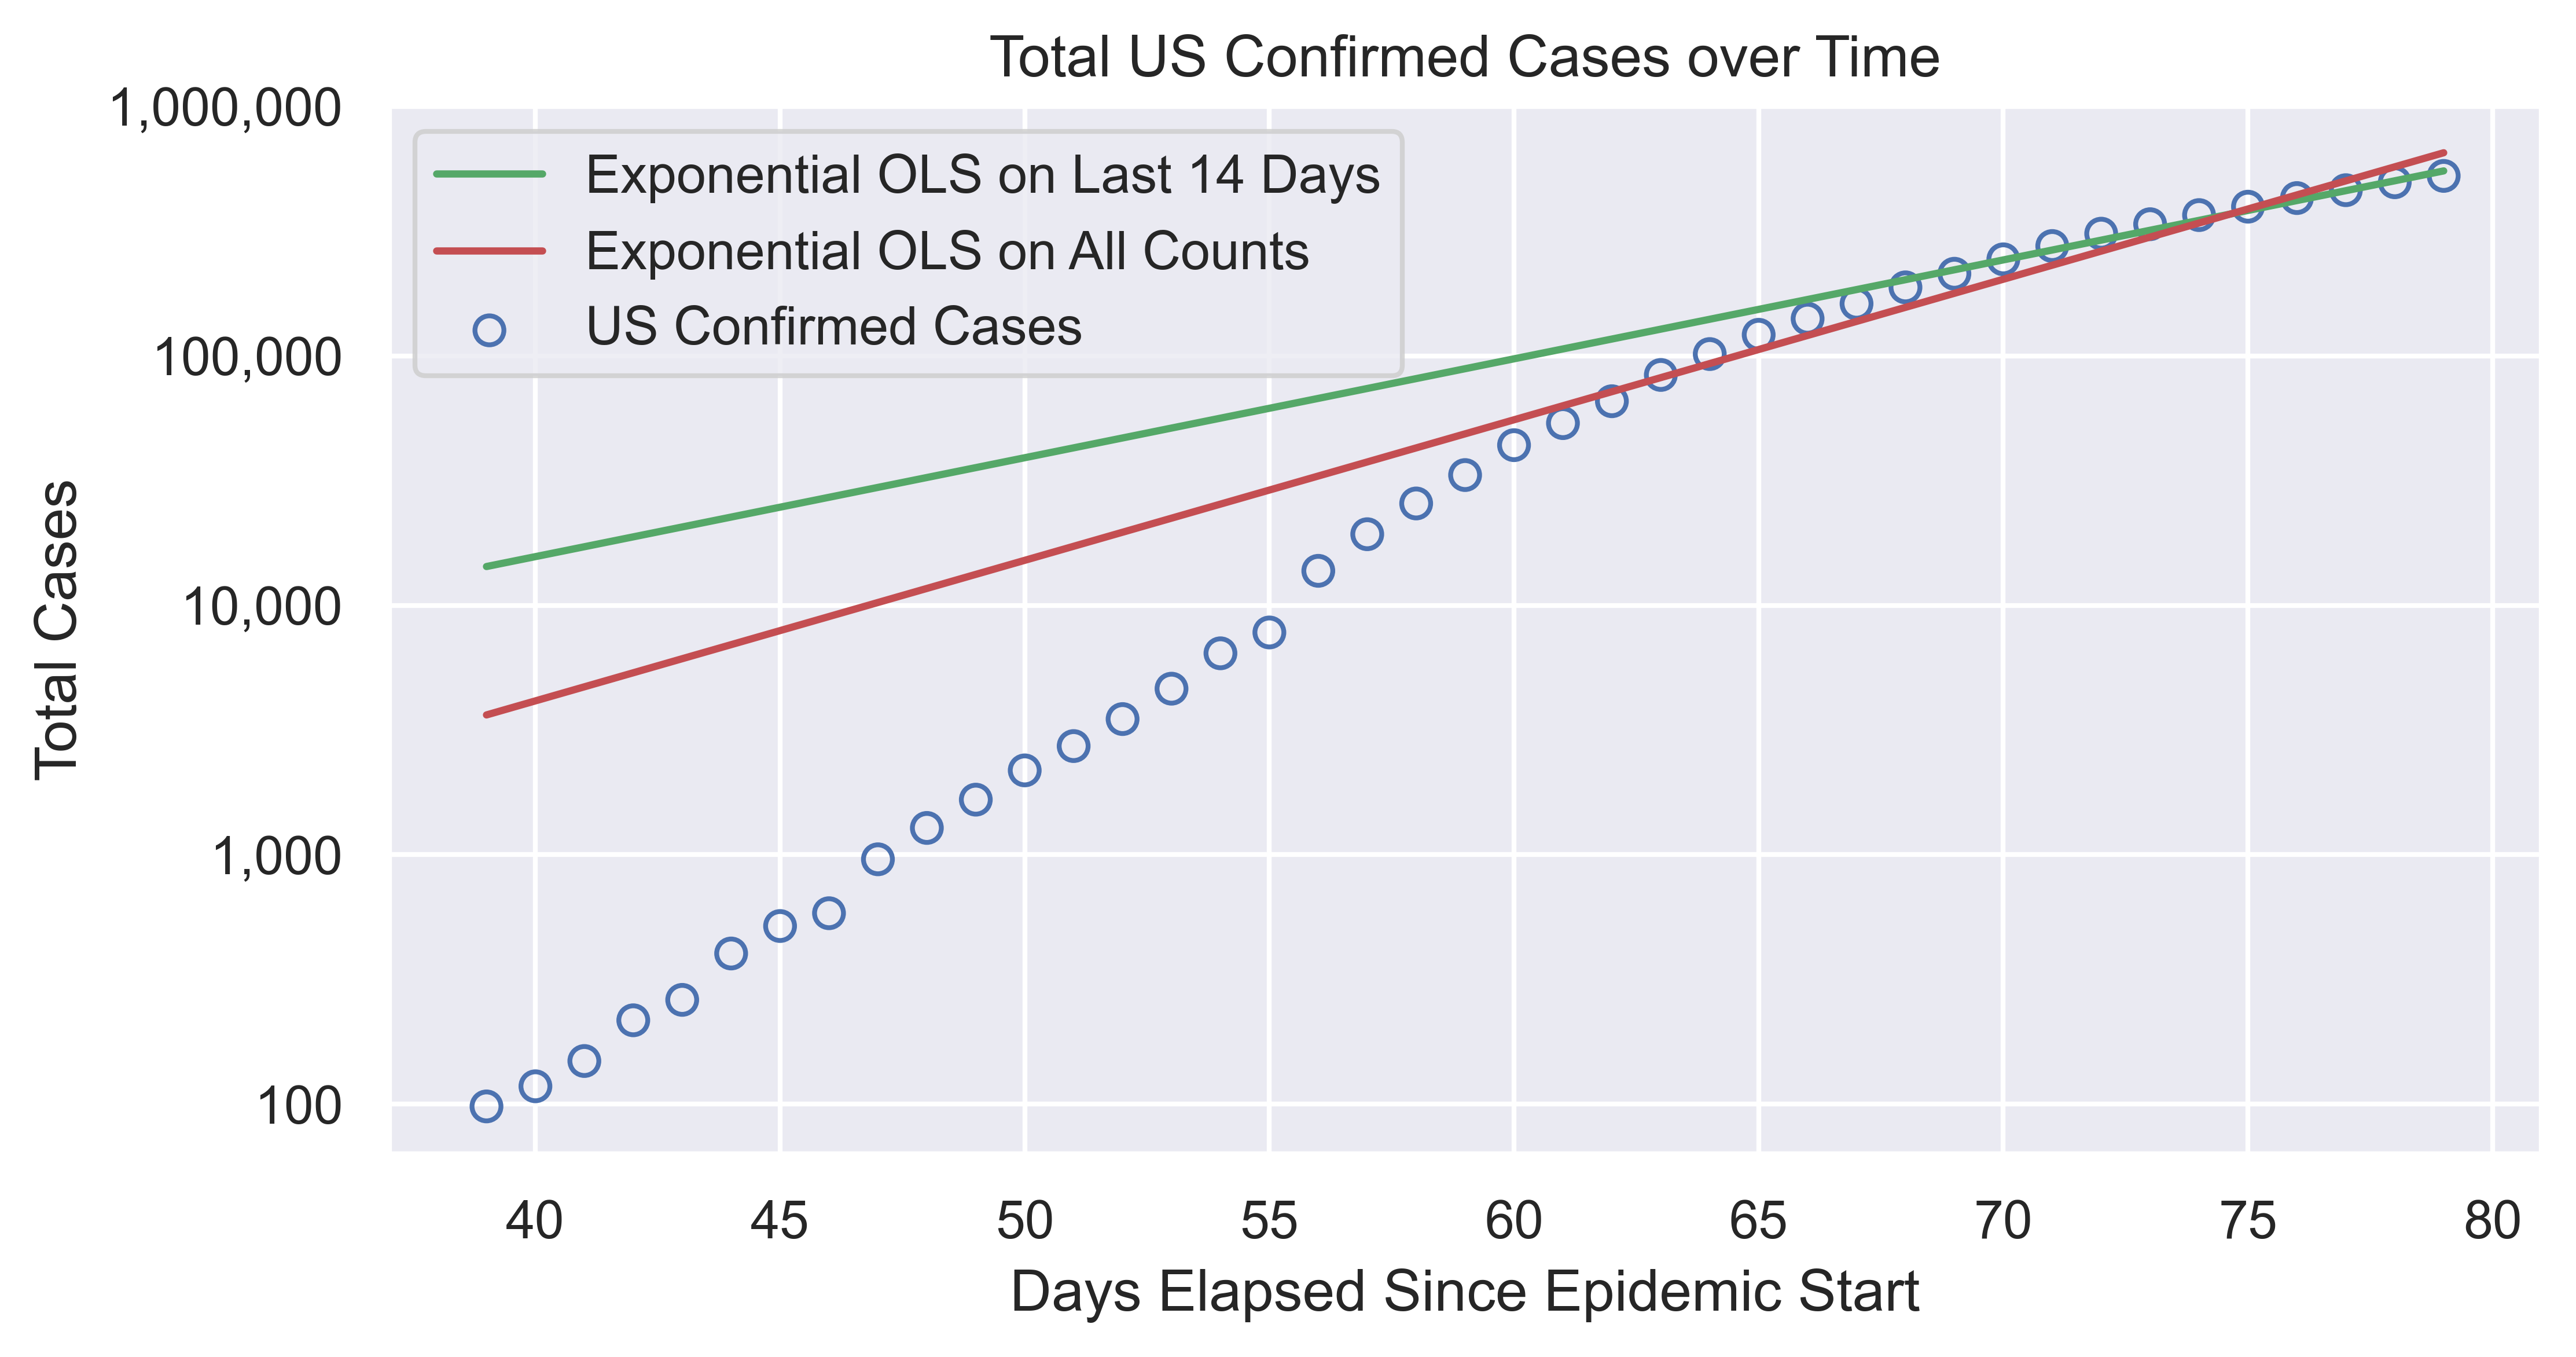

In [126]:
## Make this into log v unlogged side by side comparison
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.scatter(x, y, facecolors = 'none', edgecolor = 'b', label = 'US Confirmed Cases')
ax.plot(x, y_hat_scipy, '-', color = 'g', label = 'Exponential OLS on Last 14 Days')
ax.plot(x, y_hat_numpy, '-', color = 'r', label = 'Exponential OLS on All Counts')

plt.yscale('log') 
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Total Cases')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Total US Confirmed Cases over Time')
fig.show(warn=False)

### Using weighted local regression (LOWESS)

In [29]:
x = US_trimmed.DaysElapsed.values
y = US_trimmed.Confirmed.values

In [30]:
y_hat = sm.nonparametric.lowess(y, x, frac=7/len(x), it=0, return_sorted=False)

d = 3
x_range, y_pred = predict_lowess(x, y_hat, days=d, extend=False)

preds = pd.DataFrame(list(zip(x_range, np.around(y_pred,0))), columns =['DaysElapsed', 'Confirmed Predictions']) 
preds

,DaysElapsed,Confirmed Predictions
0,80,559994.0
1,81,592640.0
2,82,625286.0


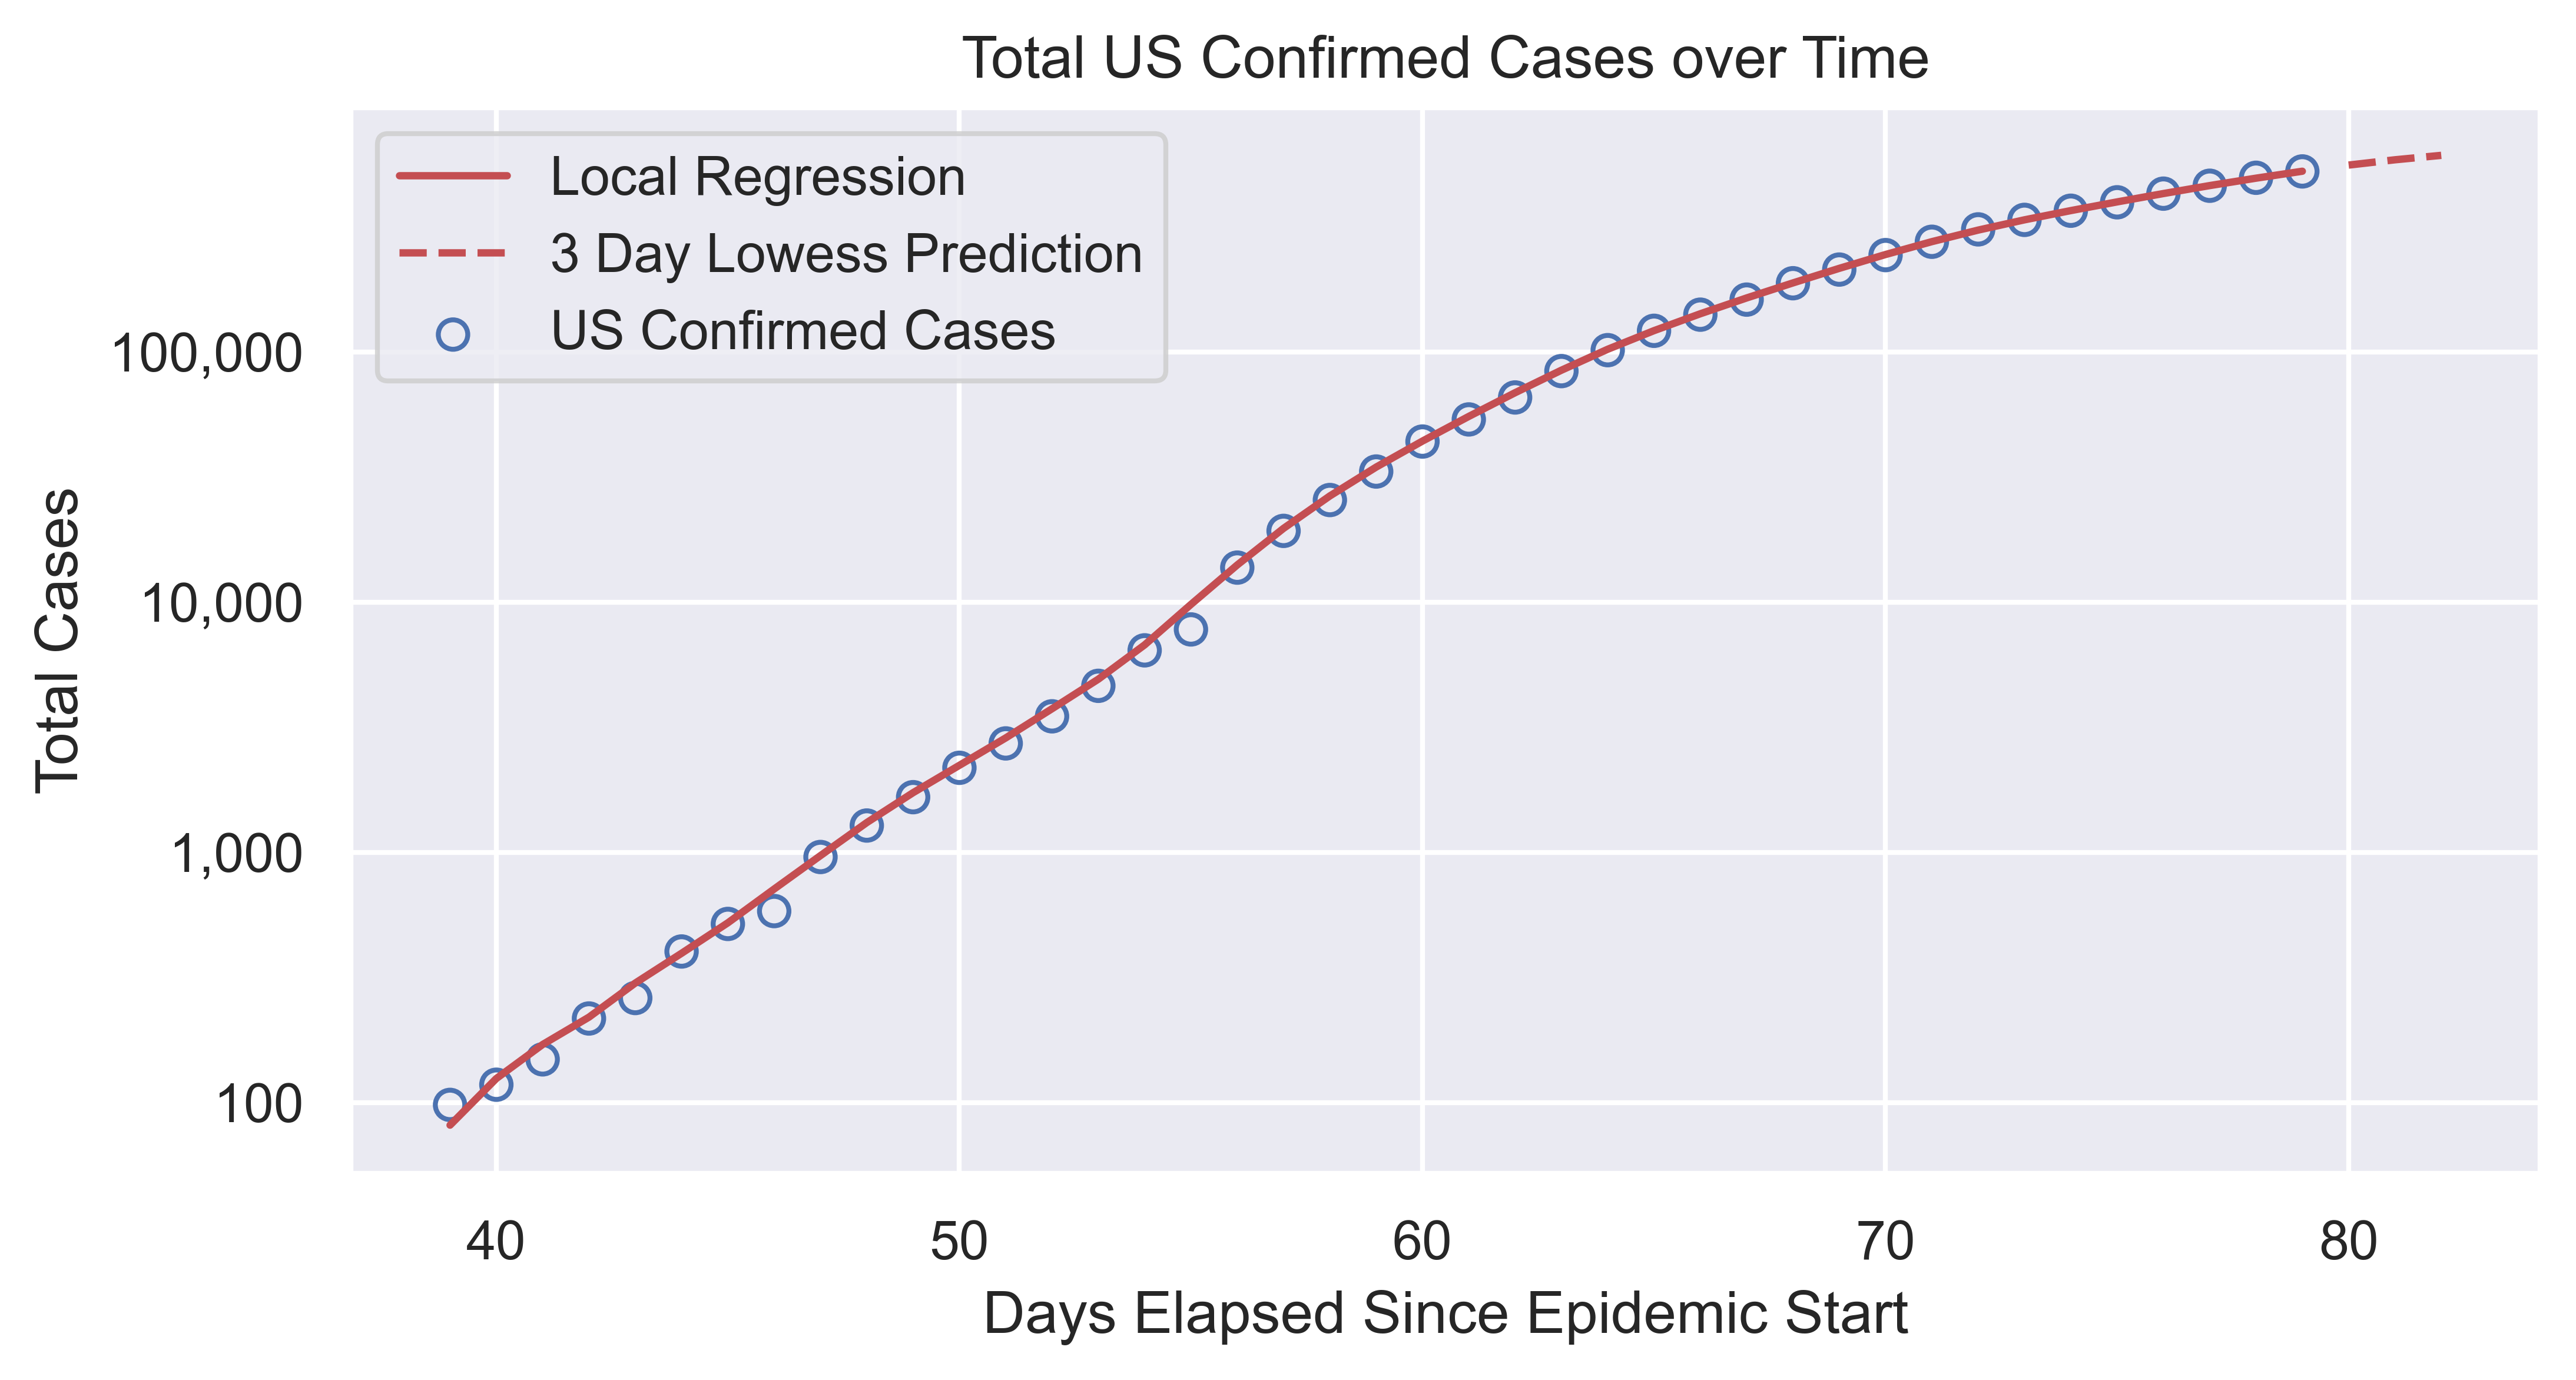

In [129]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.scatter(x, y, facecolors = 'none', edgecolor = 'b', label = 'US Confirmed Cases')
ax.plot(x, y_hat, color = 'r', label = 'Local Regression')

ax.plot(x_range, y_pred, '--', color = 'r', label = '{} Day Lowess Prediction'.format(d))

plt.yscale('log')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Total Cases')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Total US Confirmed Cases over Time')
fig.show(warn=False)

### Using compounded growth

Using the logarithmic approximation

In [131]:
x = US_trimmed.DaysElapsed.values[1:]
r = US_trimmed.Confirmed_Log.diff(periods=1).values[1:] 

In [134]:
# Only consider the last 2 weeks to regress on
params = np.polyfit(x[-14:],r[-14:],deg=1)
r_hat = x*params[0]+params[1]

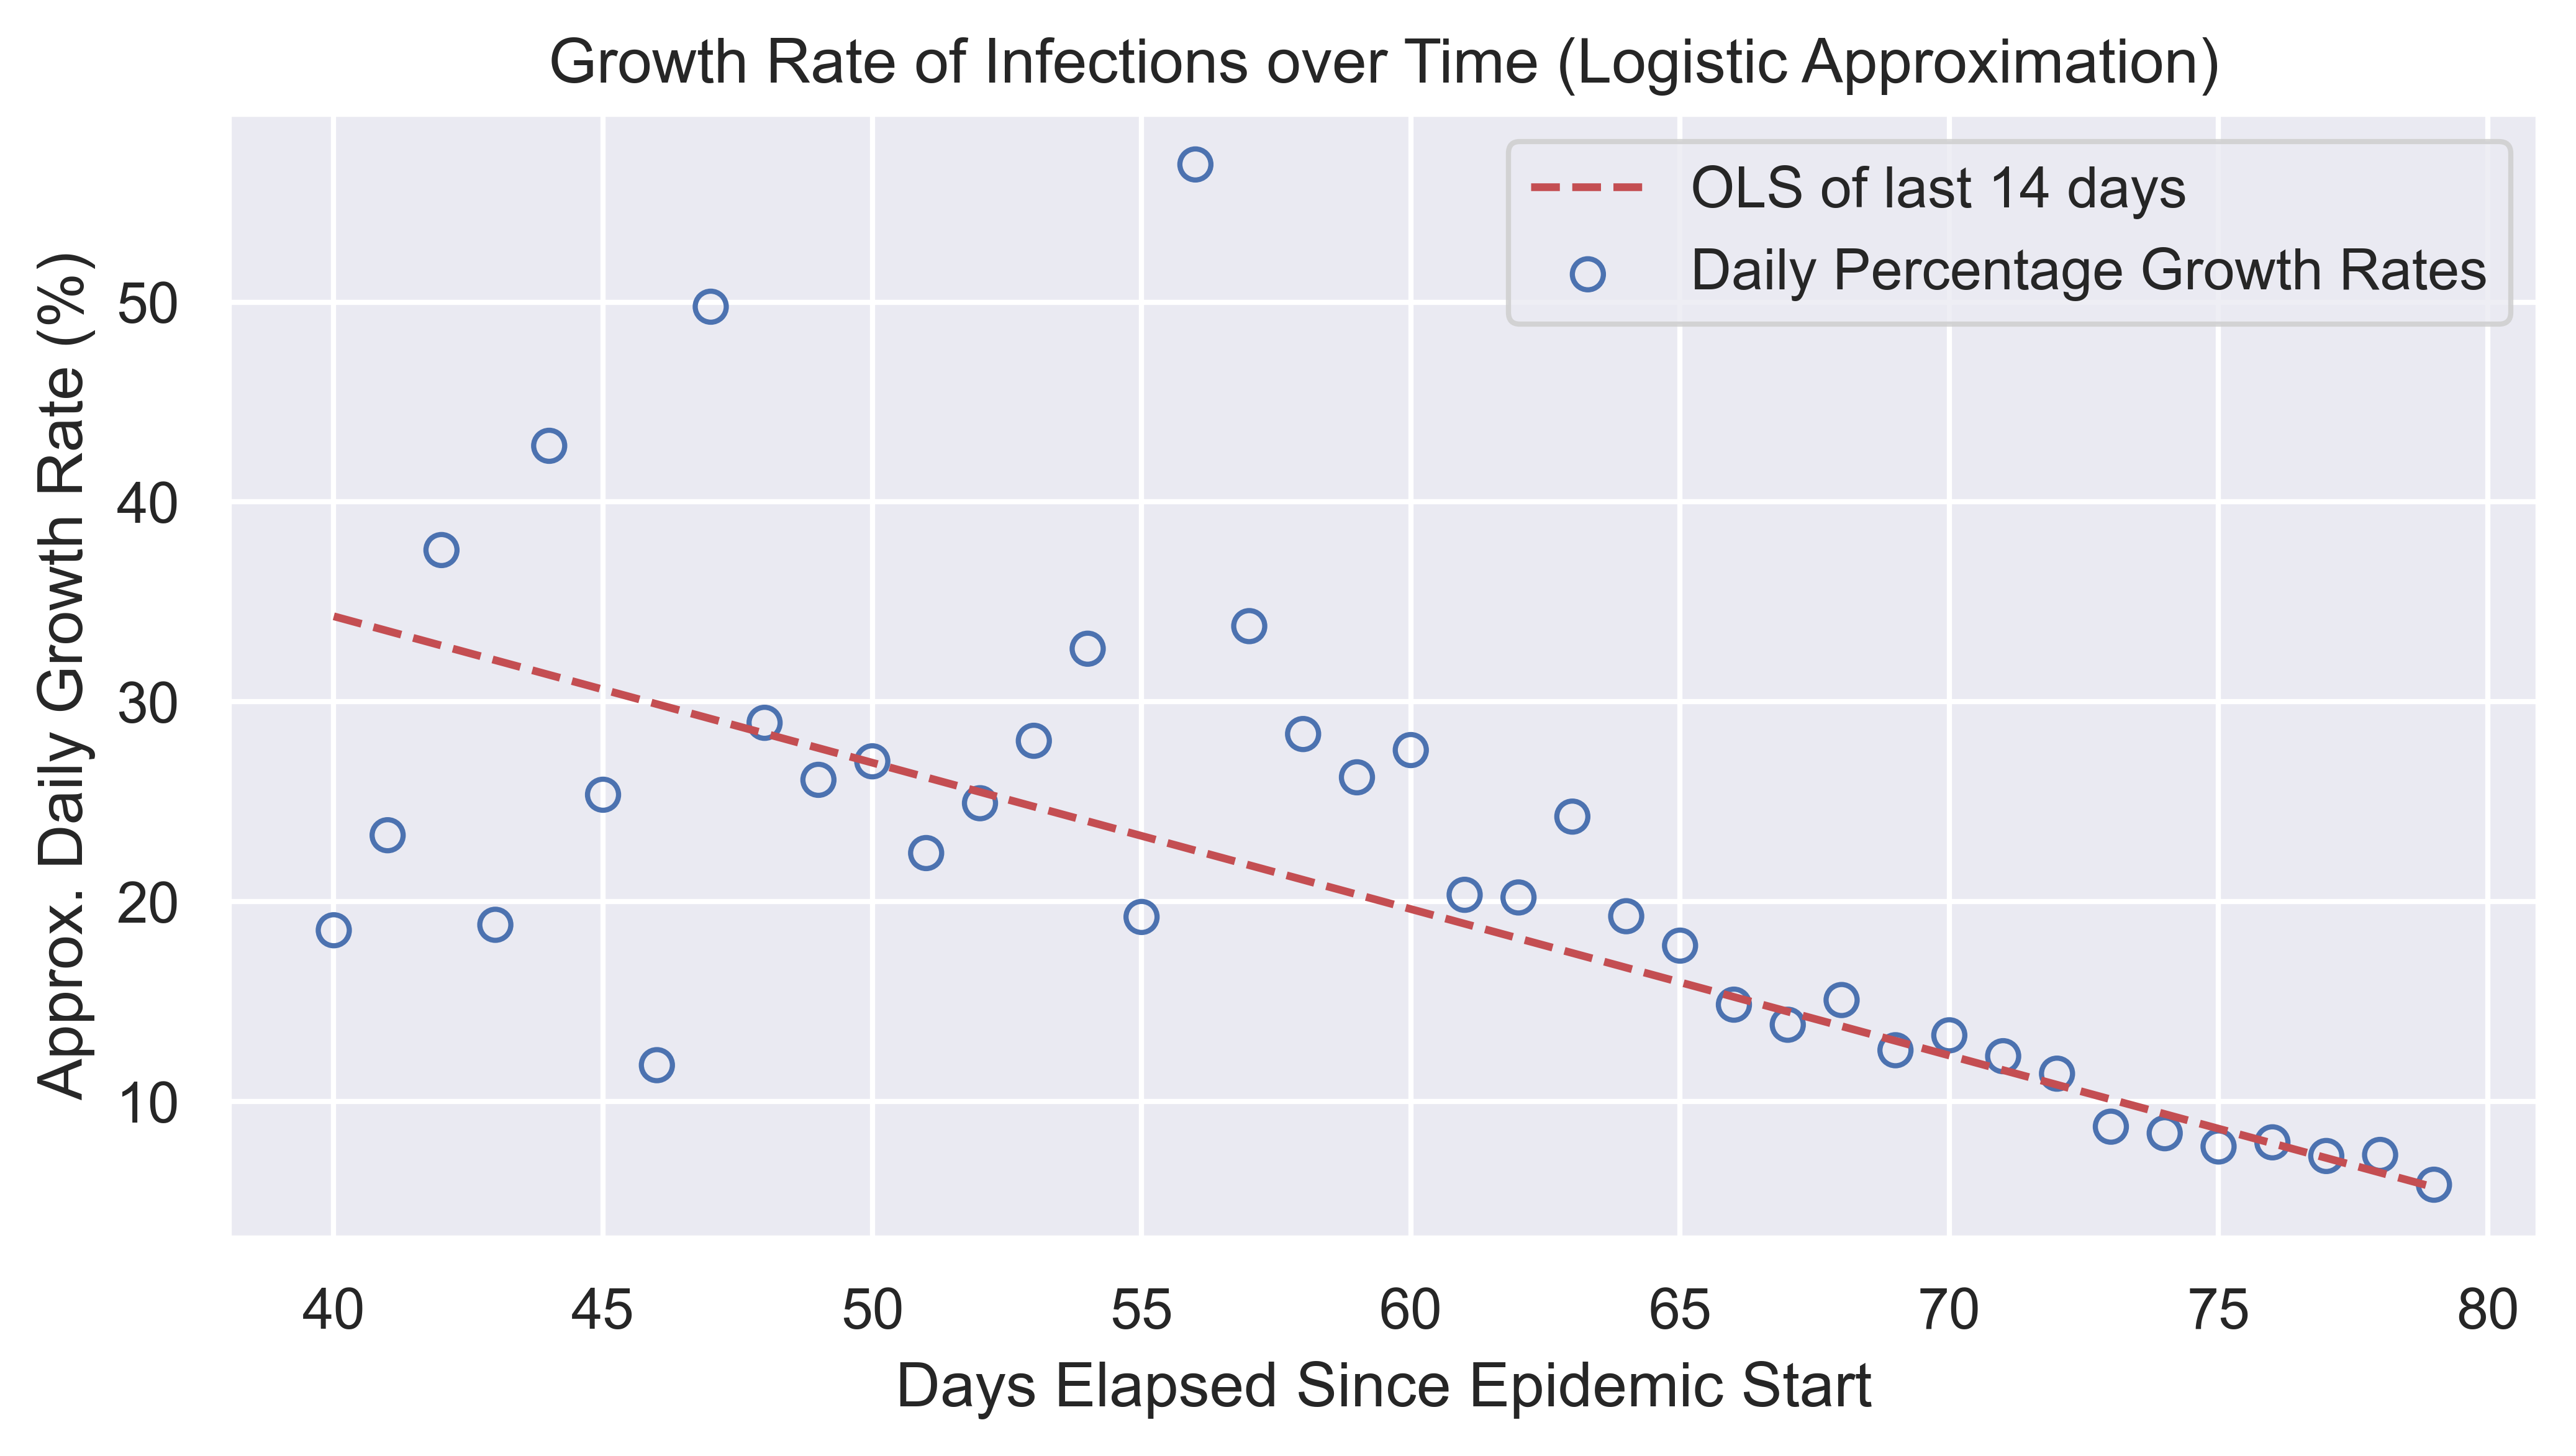

In [135]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.scatter(x, r*100, facecolors = 'none', edgecolor = 'b', label = 'Daily Percentage Growth Rates')
ax.plot(x, r_hat*100, '--', color = 'r', label = 'OLS of last 14 days')

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Approx. Daily Growth Rate (%)')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Growth Rate of Infections over Time (Logistic Approximation)')
fig.show(warn=False)

Using actual daily growth rate in confirmed cases

In [141]:
x = US_trimmed.DaysElapsed.values[1:]
r = (US_trimmed.Confirmed/US_trimmed.Confirmed.shift(1)).values[1:]
y = US_trimmed.Confirmed.values[1:]

In [142]:
# Only consider the last 2 weeks to regress on
params = np.polyfit(x[-14:],r[-14:],deg=1)
r_hat = x*params[0]+params[1]

r2_score(r[-14:], r_hat[-14:])

0.9319071525839852

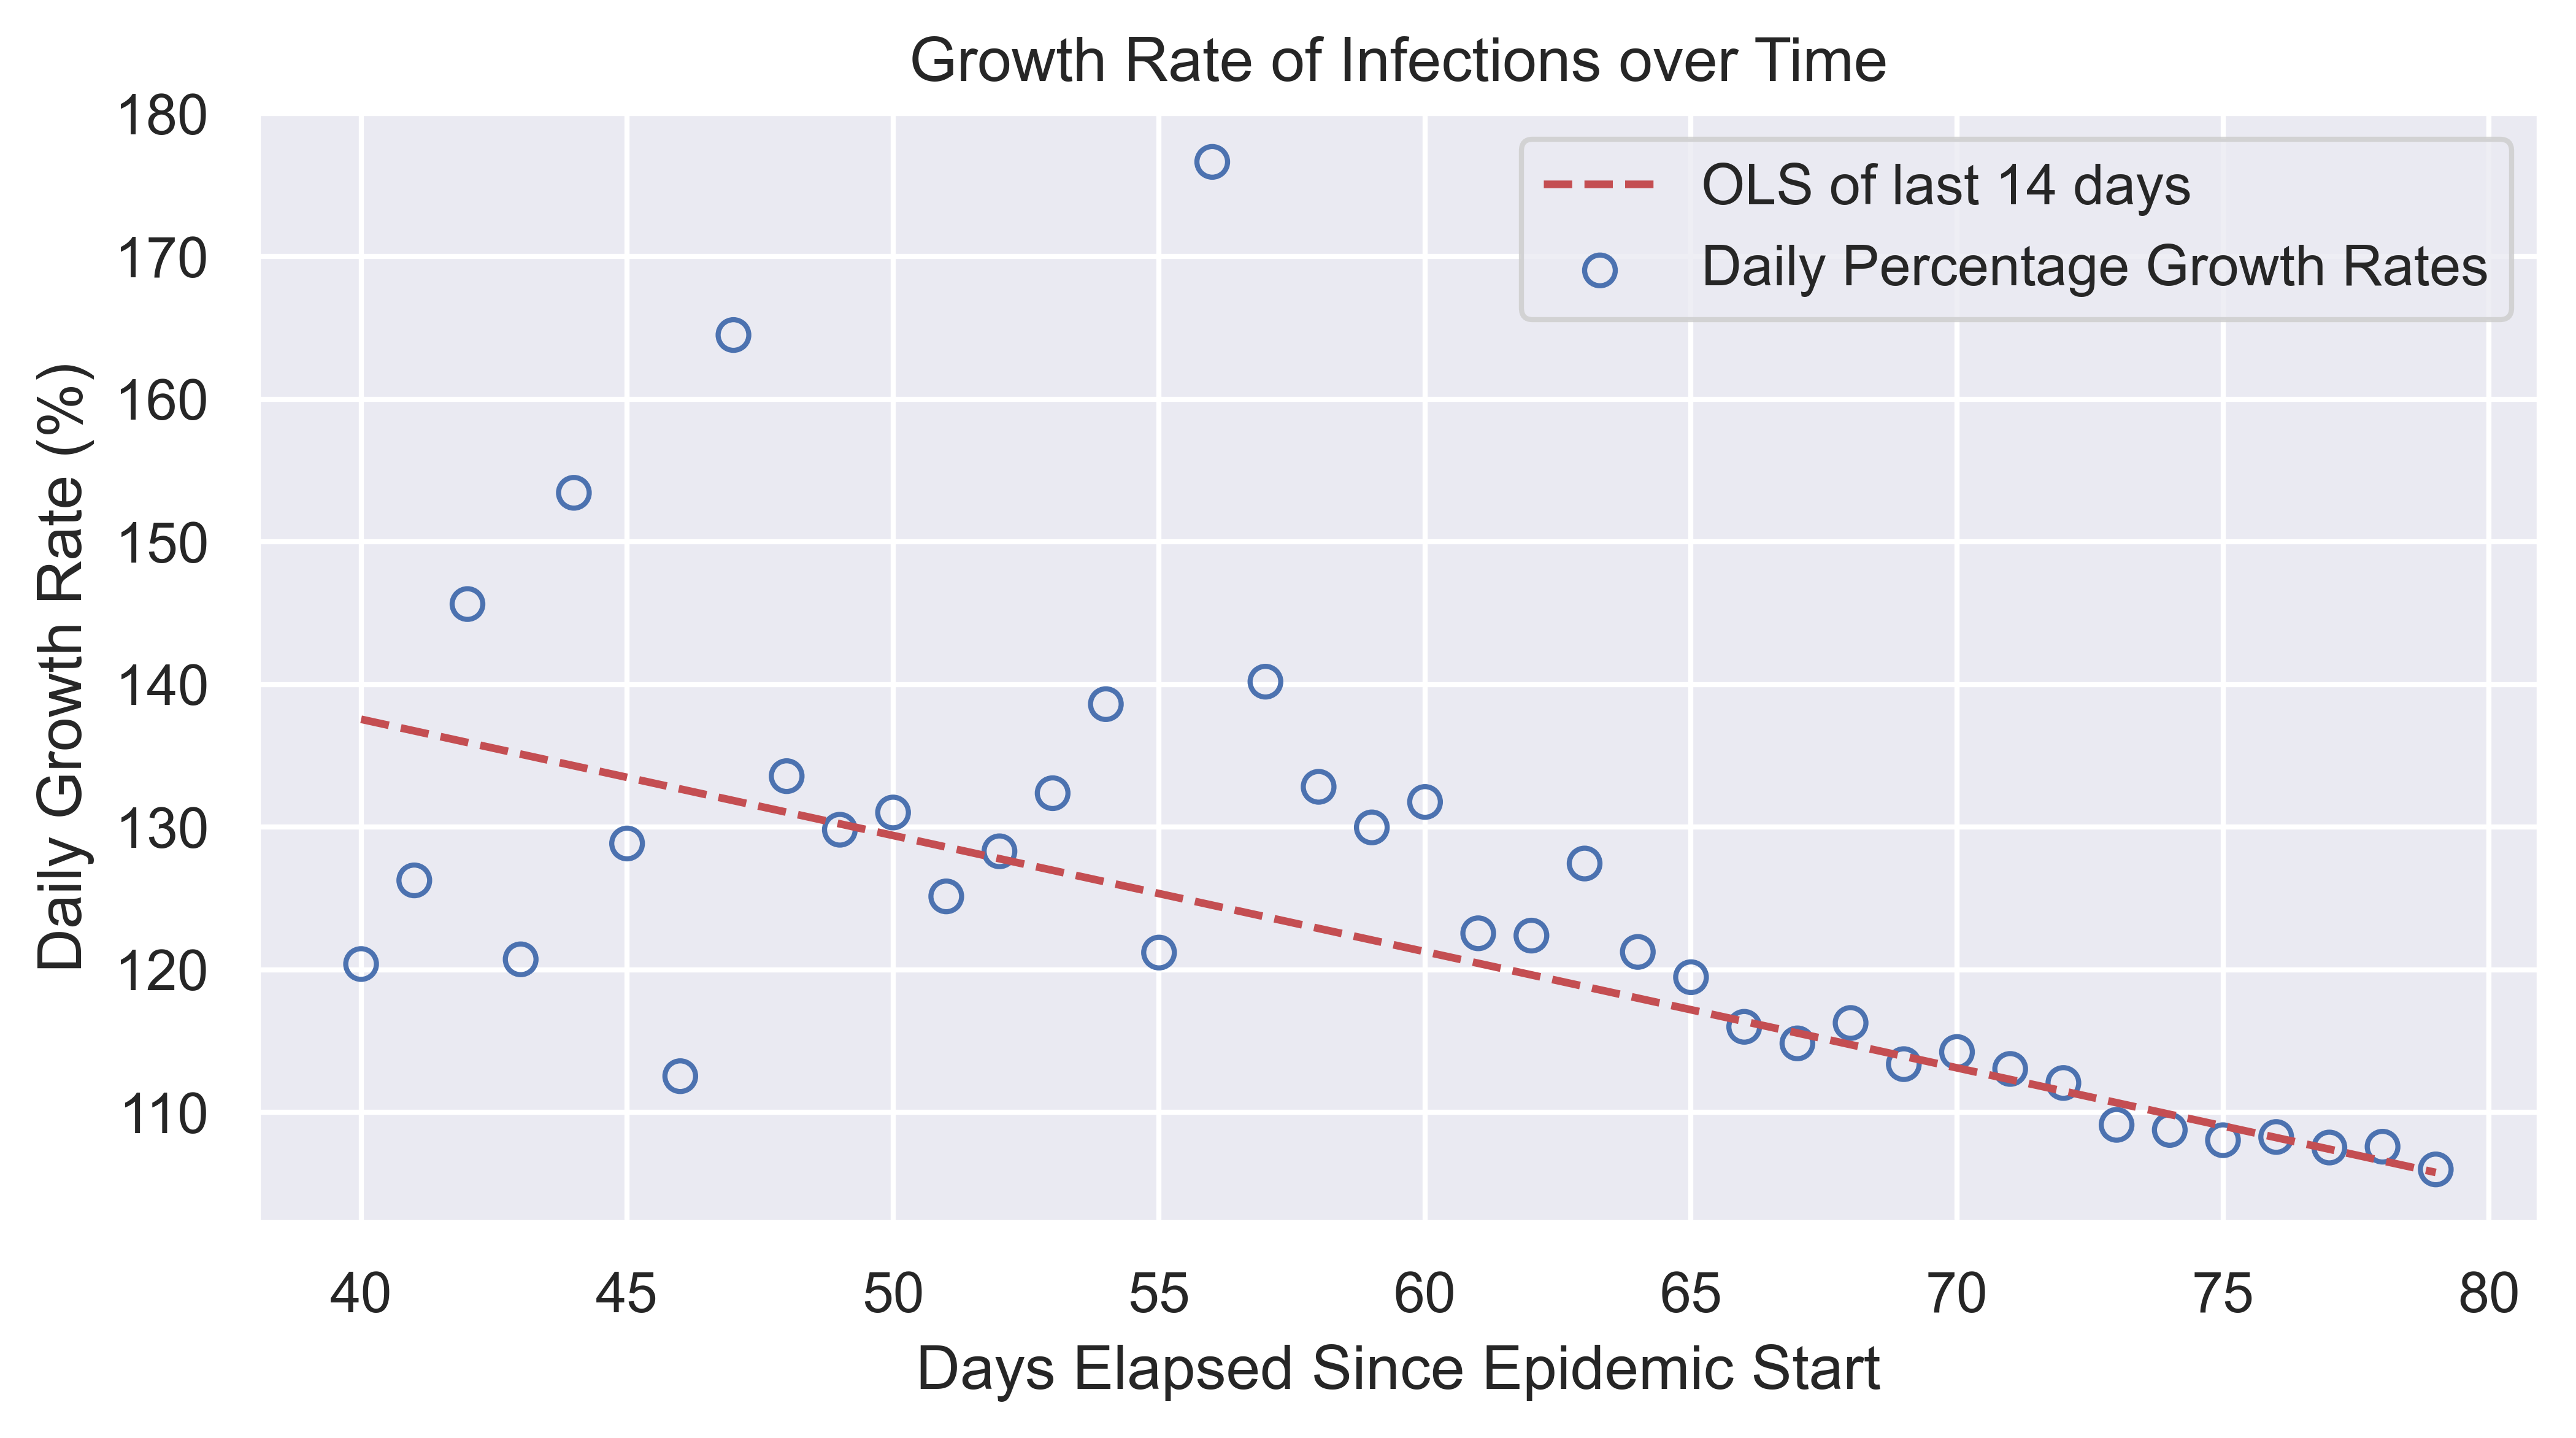

In [143]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.scatter(x, r*100, facecolors = 'none', edgecolor = 'b', label = 'Daily Percentage Growth Rates')
ax.plot(x, r_hat*100, '--', color = 'r', label = 'OLS of last 14 days')

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Daily Growth Rate (%)')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Growth Rate of Infections over Time')
fig.show(warn=False)

In [144]:
# Predict cases from growth rate
x_range, y_pred, r_pred = predict_growth(x, y, r, params, days=3)
preds = pd.DataFrame({'DaysElapsed':x_range, 'ConfirmedPred':y_pred, 'GrowthRatePred':r_pred})
preds

,DaysElapsed,ConfirmedPred,GrowthRatePred
0,80,558052.803561,1.049866
1,81,585880.598540,1.041722
2,82,610324.586168,1.033578


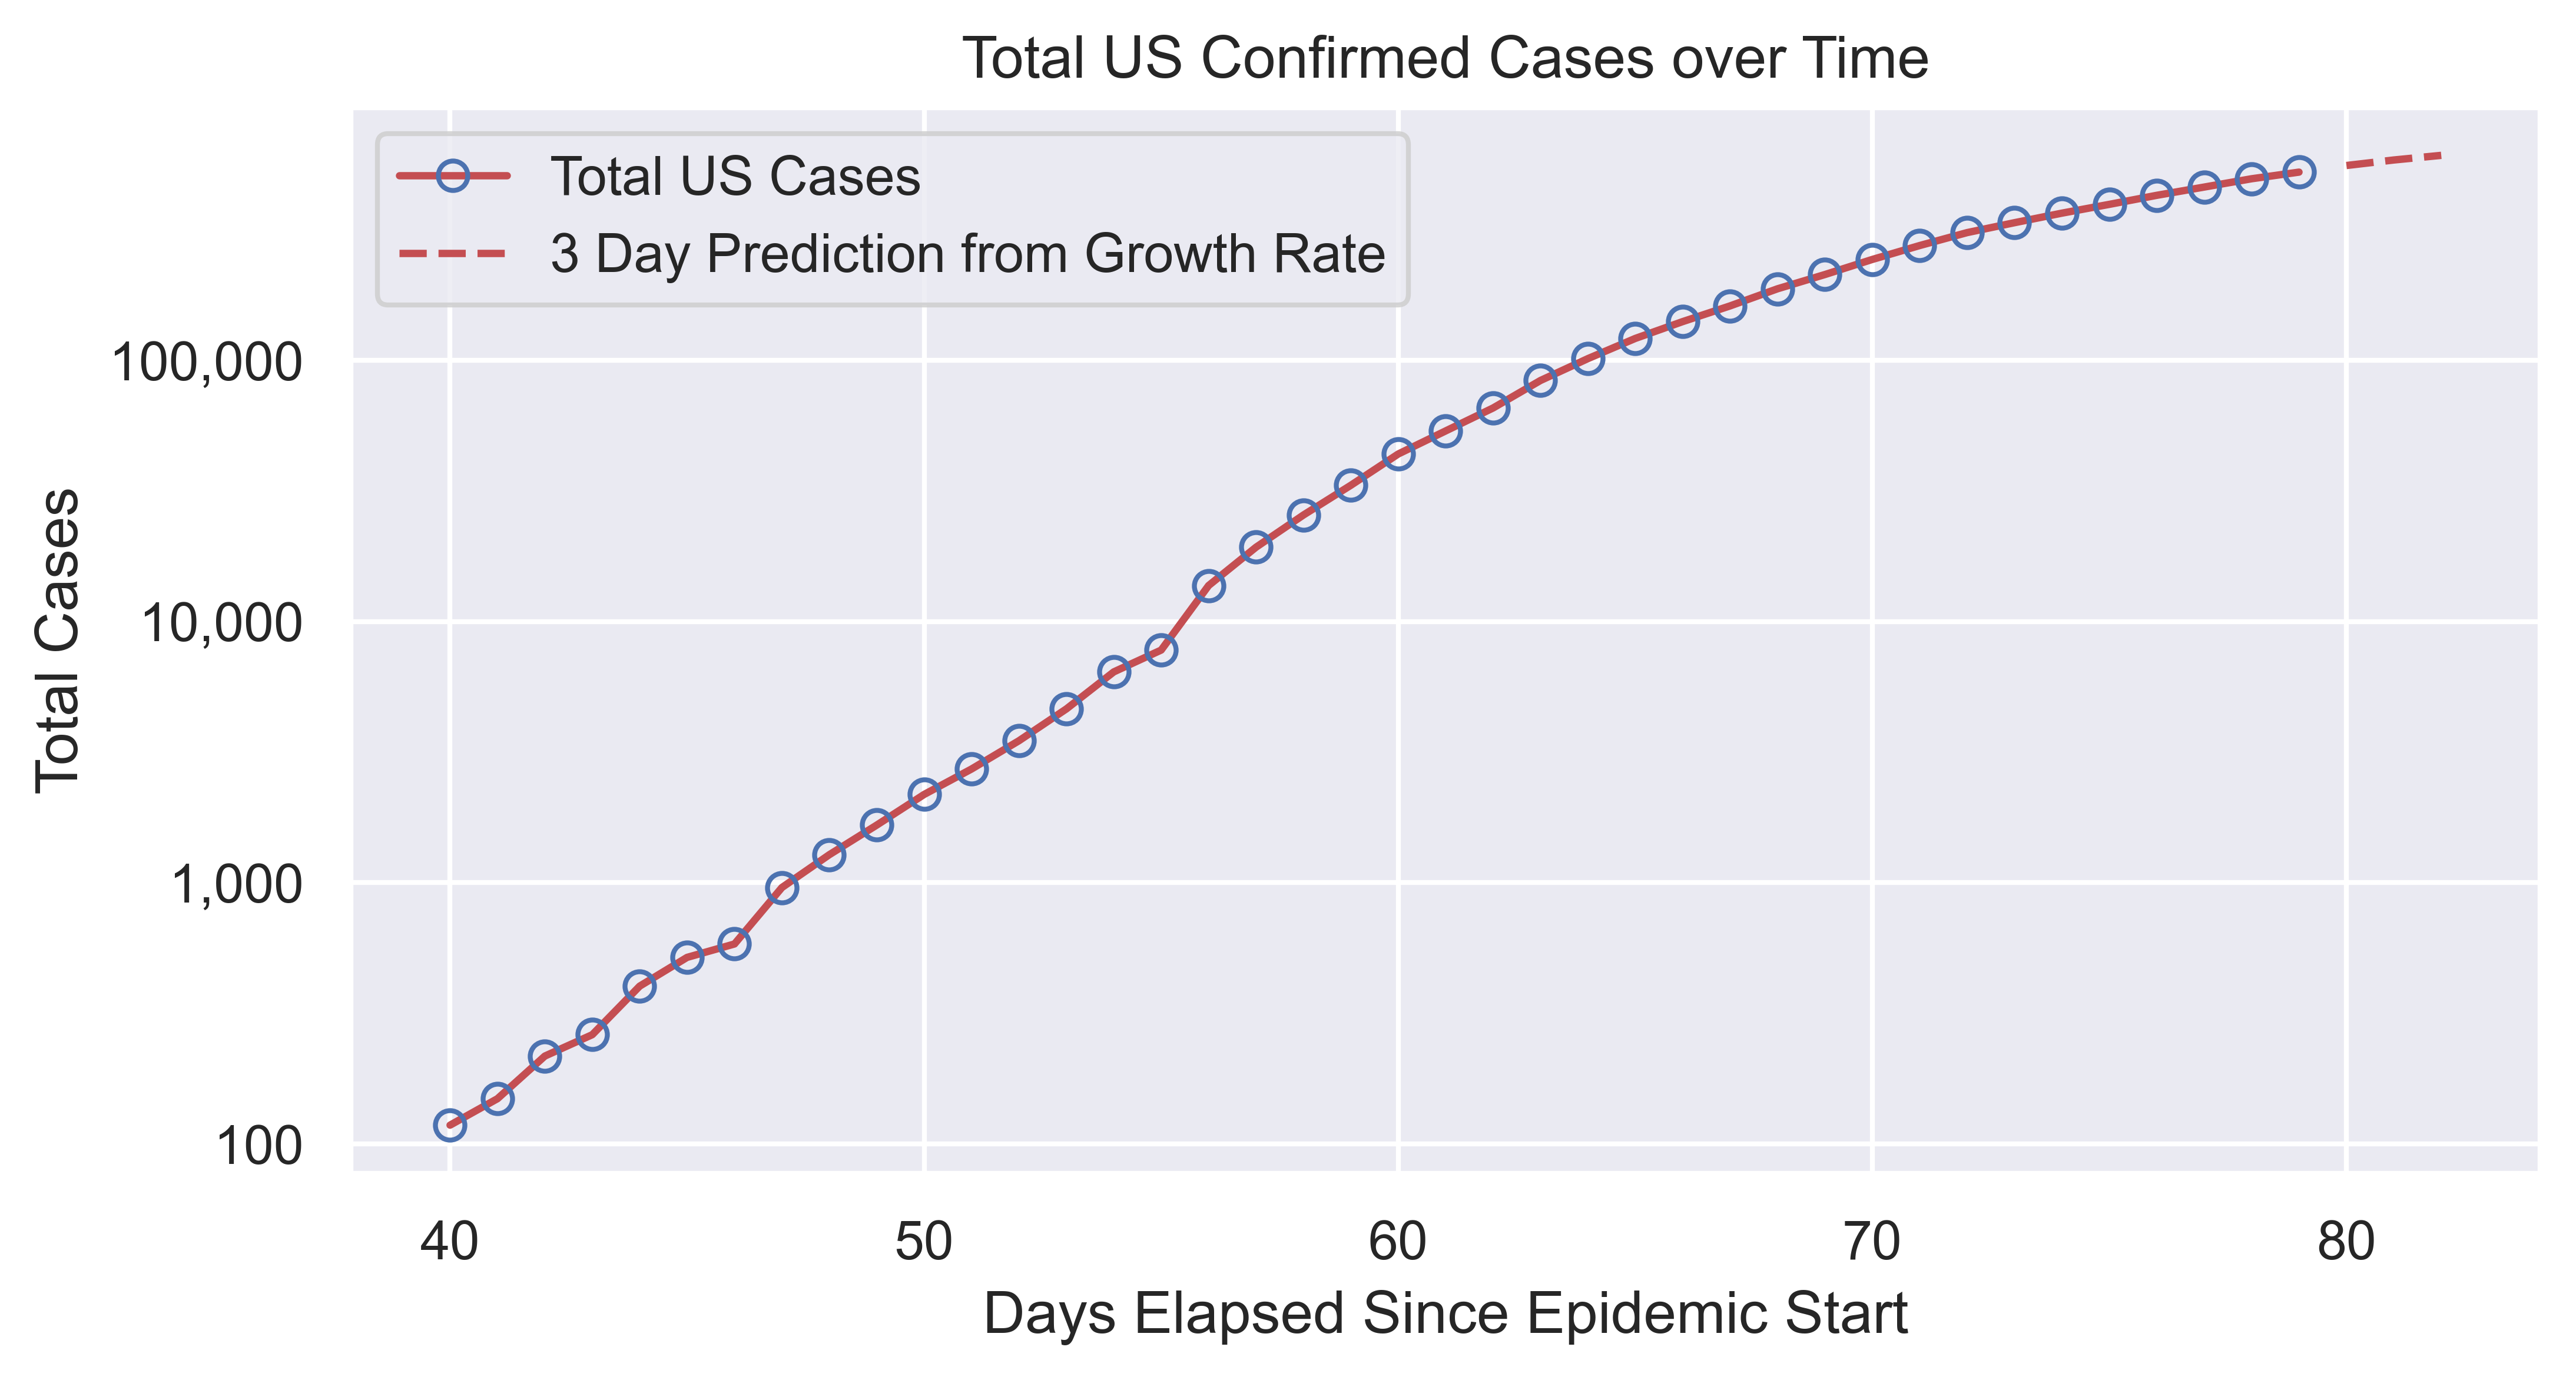

In [150]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.plot(x, y, 'o-', markerfacecolor = 'none', markeredgecolor = 'b', color='r', label = 'Total US Cases')
ax.plot(x_range, y_pred, '--', color = 'r', label = '{} Day Prediction from Growth Rate'.format(d))

plt.yscale('log')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Total Cases')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Total US Confirmed Cases over Time')
fig.show(warn=False)

### Regressing Logistic

Adapted from https://www.kaggle.com/lucaalbrizzo/robusteness-fits-and-mortality-rates-for-covid-19

In [98]:
from lmfit.models import ExponentialModel

model_exp = ExponentialModel()
params_exp = model_exp.guess(US_trimmed.Confirmed, x=US_trimmed.DaysElapsed)
result_exp = model_exp.fit(US_trimmed.Confirmed, params_exp, x=US_trimmed.DaysElapsed)

result_exp.params

name,value,standard error,relative error,initial value,min,max,vary
amplitude,84.7205158,27.0707387,(31.95%),0.02189201701996698,-inf,inf,True
decay,-8.93757815,0.33971129,(3.80%),-4.352705030295819,-inf,inf,True


In [99]:
from lmfit.models import StepModel

model_log = StepModel(form='logistic')
params_log = model_log.guess(US_trimmed.Confirmed, x=US_trimmed.DaysElapsed)
result_log = model_log.fit(US_trimmed.Confirmed, params_log, x=US_trimmed.DaysElapsed)

result_log.params

name,value,standard error,relative error,initial value,min,max,vary
amplitude,656176.763,14188.1443,(2.16%),526298,-inf,inf,True
center,72.6373711,0.25278958,(0.35%),59.0,-inf,inf,True
sigma,4.89903676,0.10300710,(2.10%),5.714285714285714,0.00000000,inf,True


In [102]:
x_range = np.arange(US_trimmed.DaysElapsed.iloc[-1]+1, US_trimmed.DaysElapsed.iloc[-1]+1+3)
y_pred = model_log.eval(result_log.params, x=x_range)

preds = pd.DataFrame(list(zip(x_range, np.around(y_pred,0))), columns =['DaysElapsed', 'Confirmed Predictions']) 
preds

,DaysElapsed,Confirmed Predictions
0,80,536754.0
1,81,555418.0
2,82,571625.0


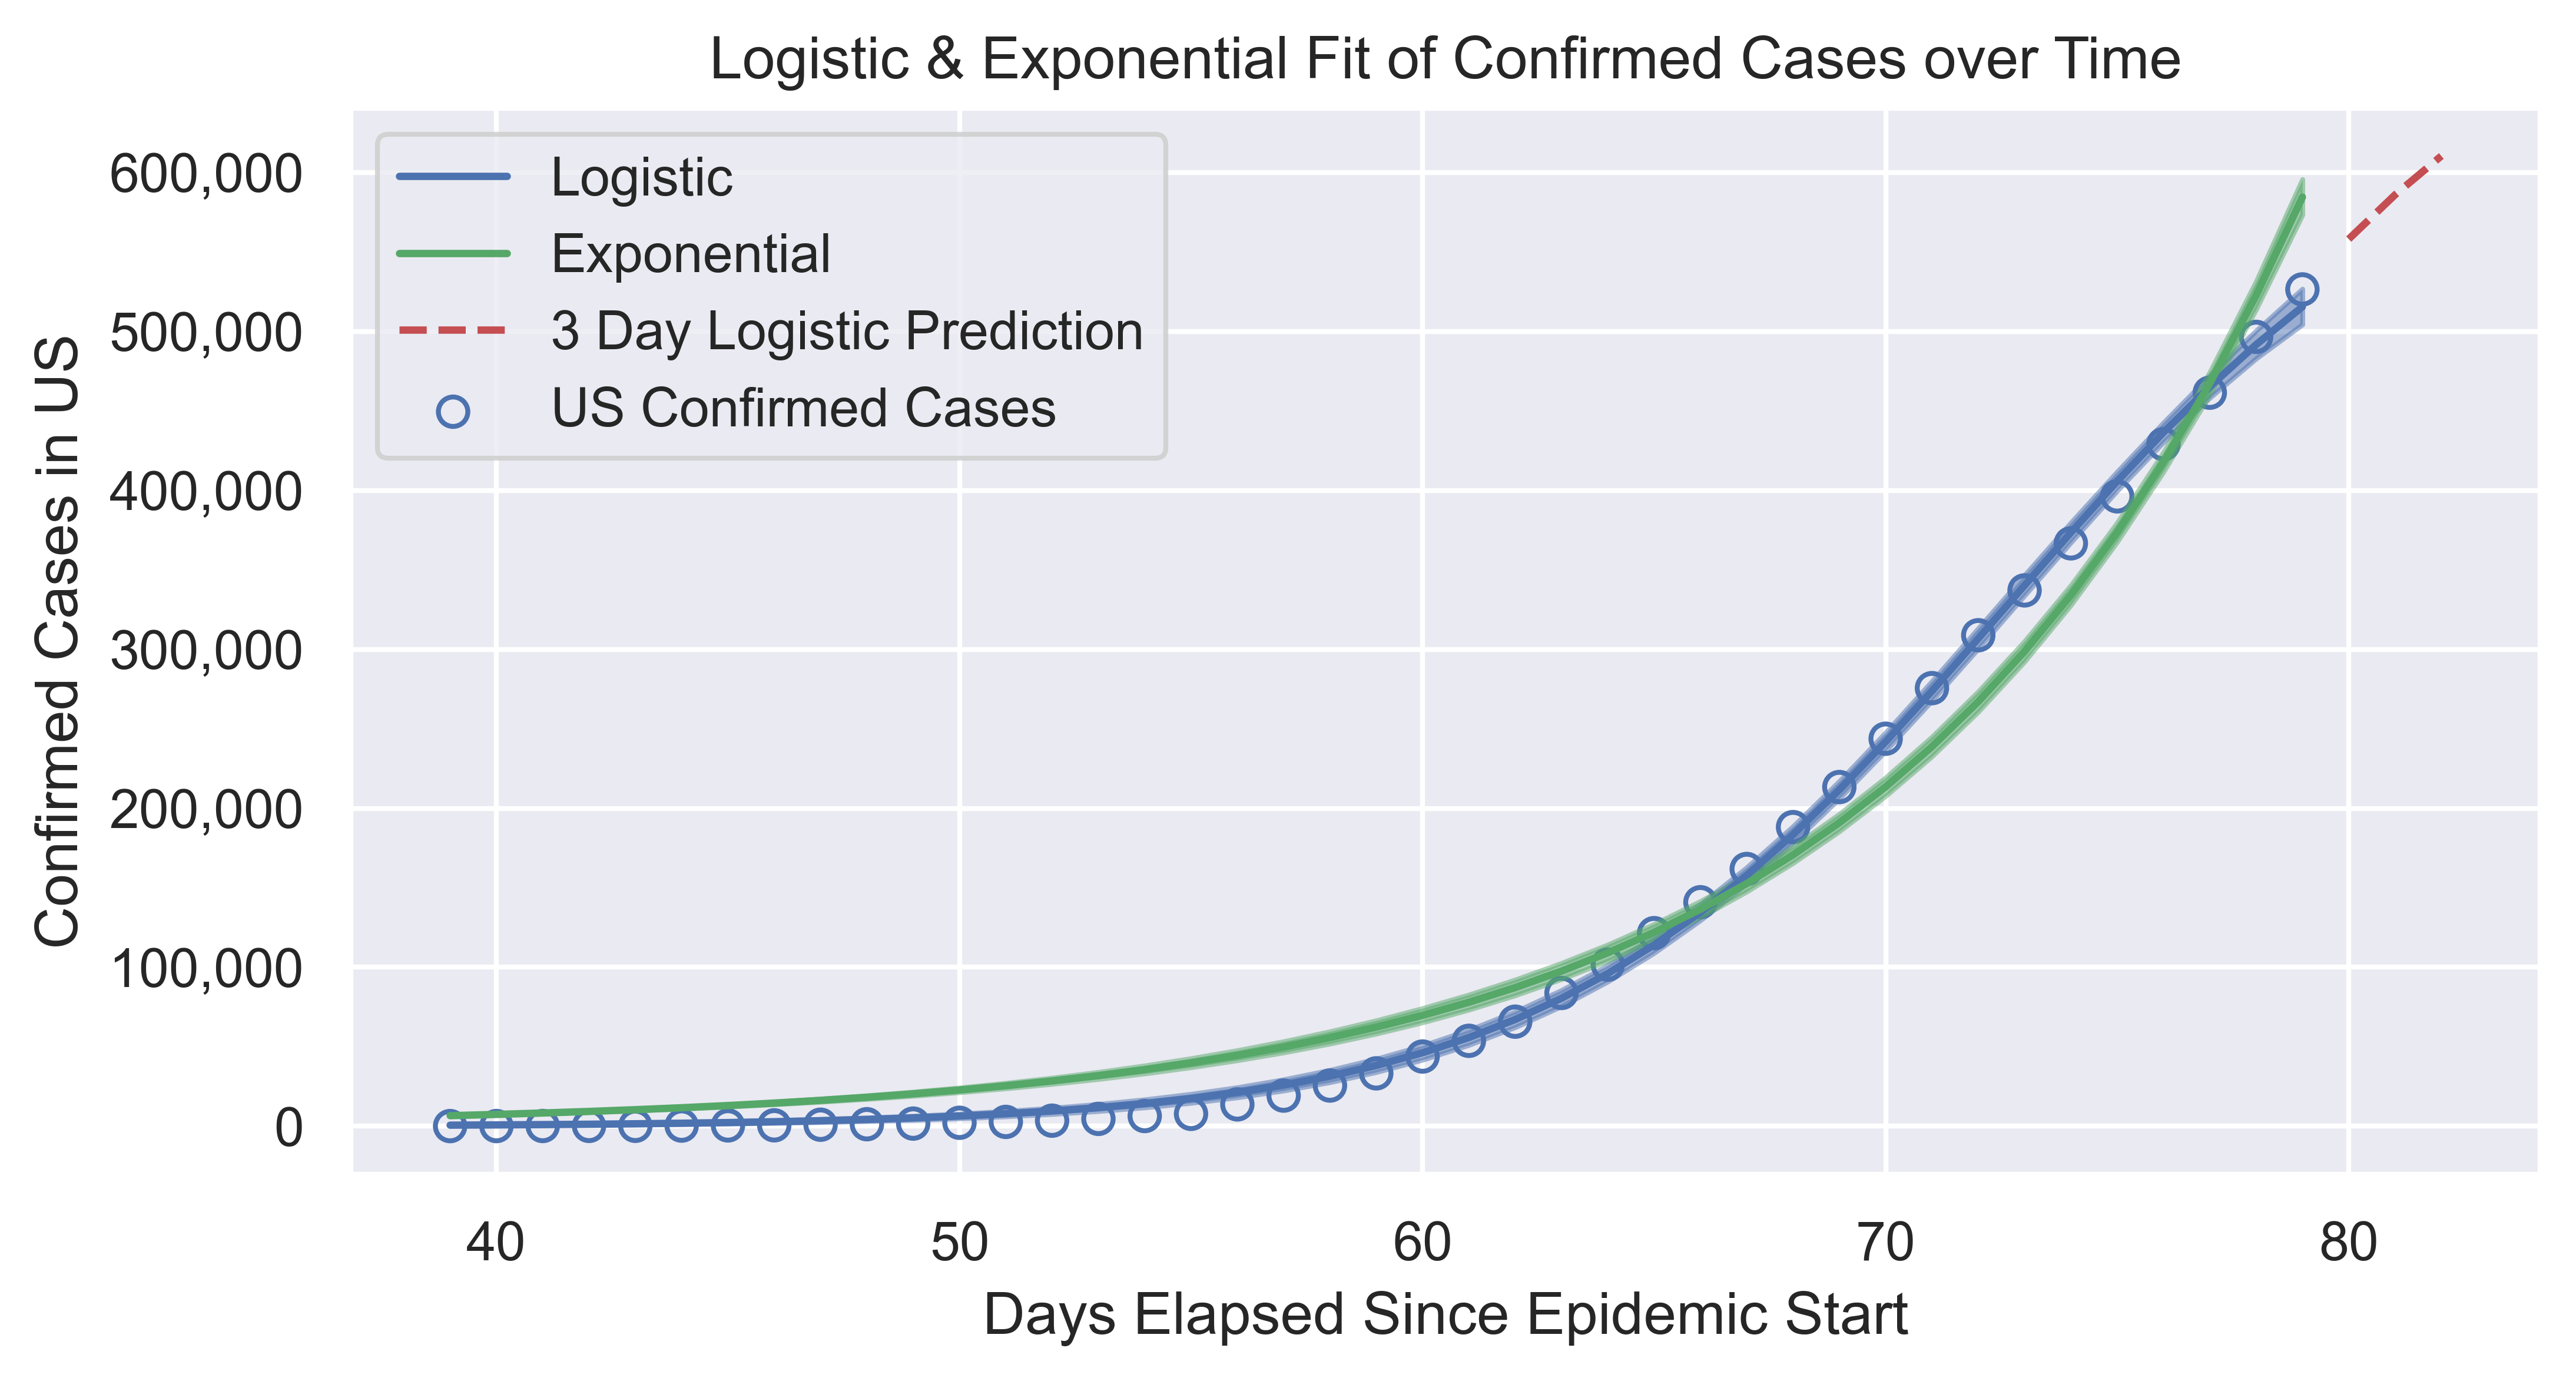

In [151]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.scatter(US_trimmed.DaysElapsed, US_trimmed.Confirmed, 
           facecolors = 'none', edgecolor = 'b', label = 'US Confirmed Cases')

ax.plot(US_trimmed.DaysElapsed, result_log.best_fit, color='b',
        label="Logistic")
ax.plot(US_trimmed.DaysElapsed, result_exp.best_fit, color='g',
        label="Exponential")

ax.plot(x_range, y_pred, '--', color = 'r', label = '{} Day Logistic Prediction'.format(d))

dely_log = result_log.eval_uncertainty(x=US_trimmed.DaysElapsed,sigma=3)
ax.fill_between(US_trimmed.DaysElapsed, 
                 result_log.best_fit-dely_log,
                 result_log.best_fit+dely_log, 
                 color='b',
                 alpha=0.5)

dely_exp = result_log.eval_uncertainty(x=US_trimmed.DaysElapsed,sigma=3)
ax.fill_between(US_trimmed.DaysElapsed, 
                 result_exp.best_fit-dely_exp,
                 result_exp.best_fit+dely_exp, 
                 color='g',
                 alpha=0.5)

# plt.yscale('log')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Confirmed Cases in US')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Logistic & Exponential Fit of Confirmed Cases over Time')
fig.show(warn=False)

COMPOSITE LMFIT MODELS

## SIR Theory

In [40]:
## From https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
from scipy.integrate import odeint

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T


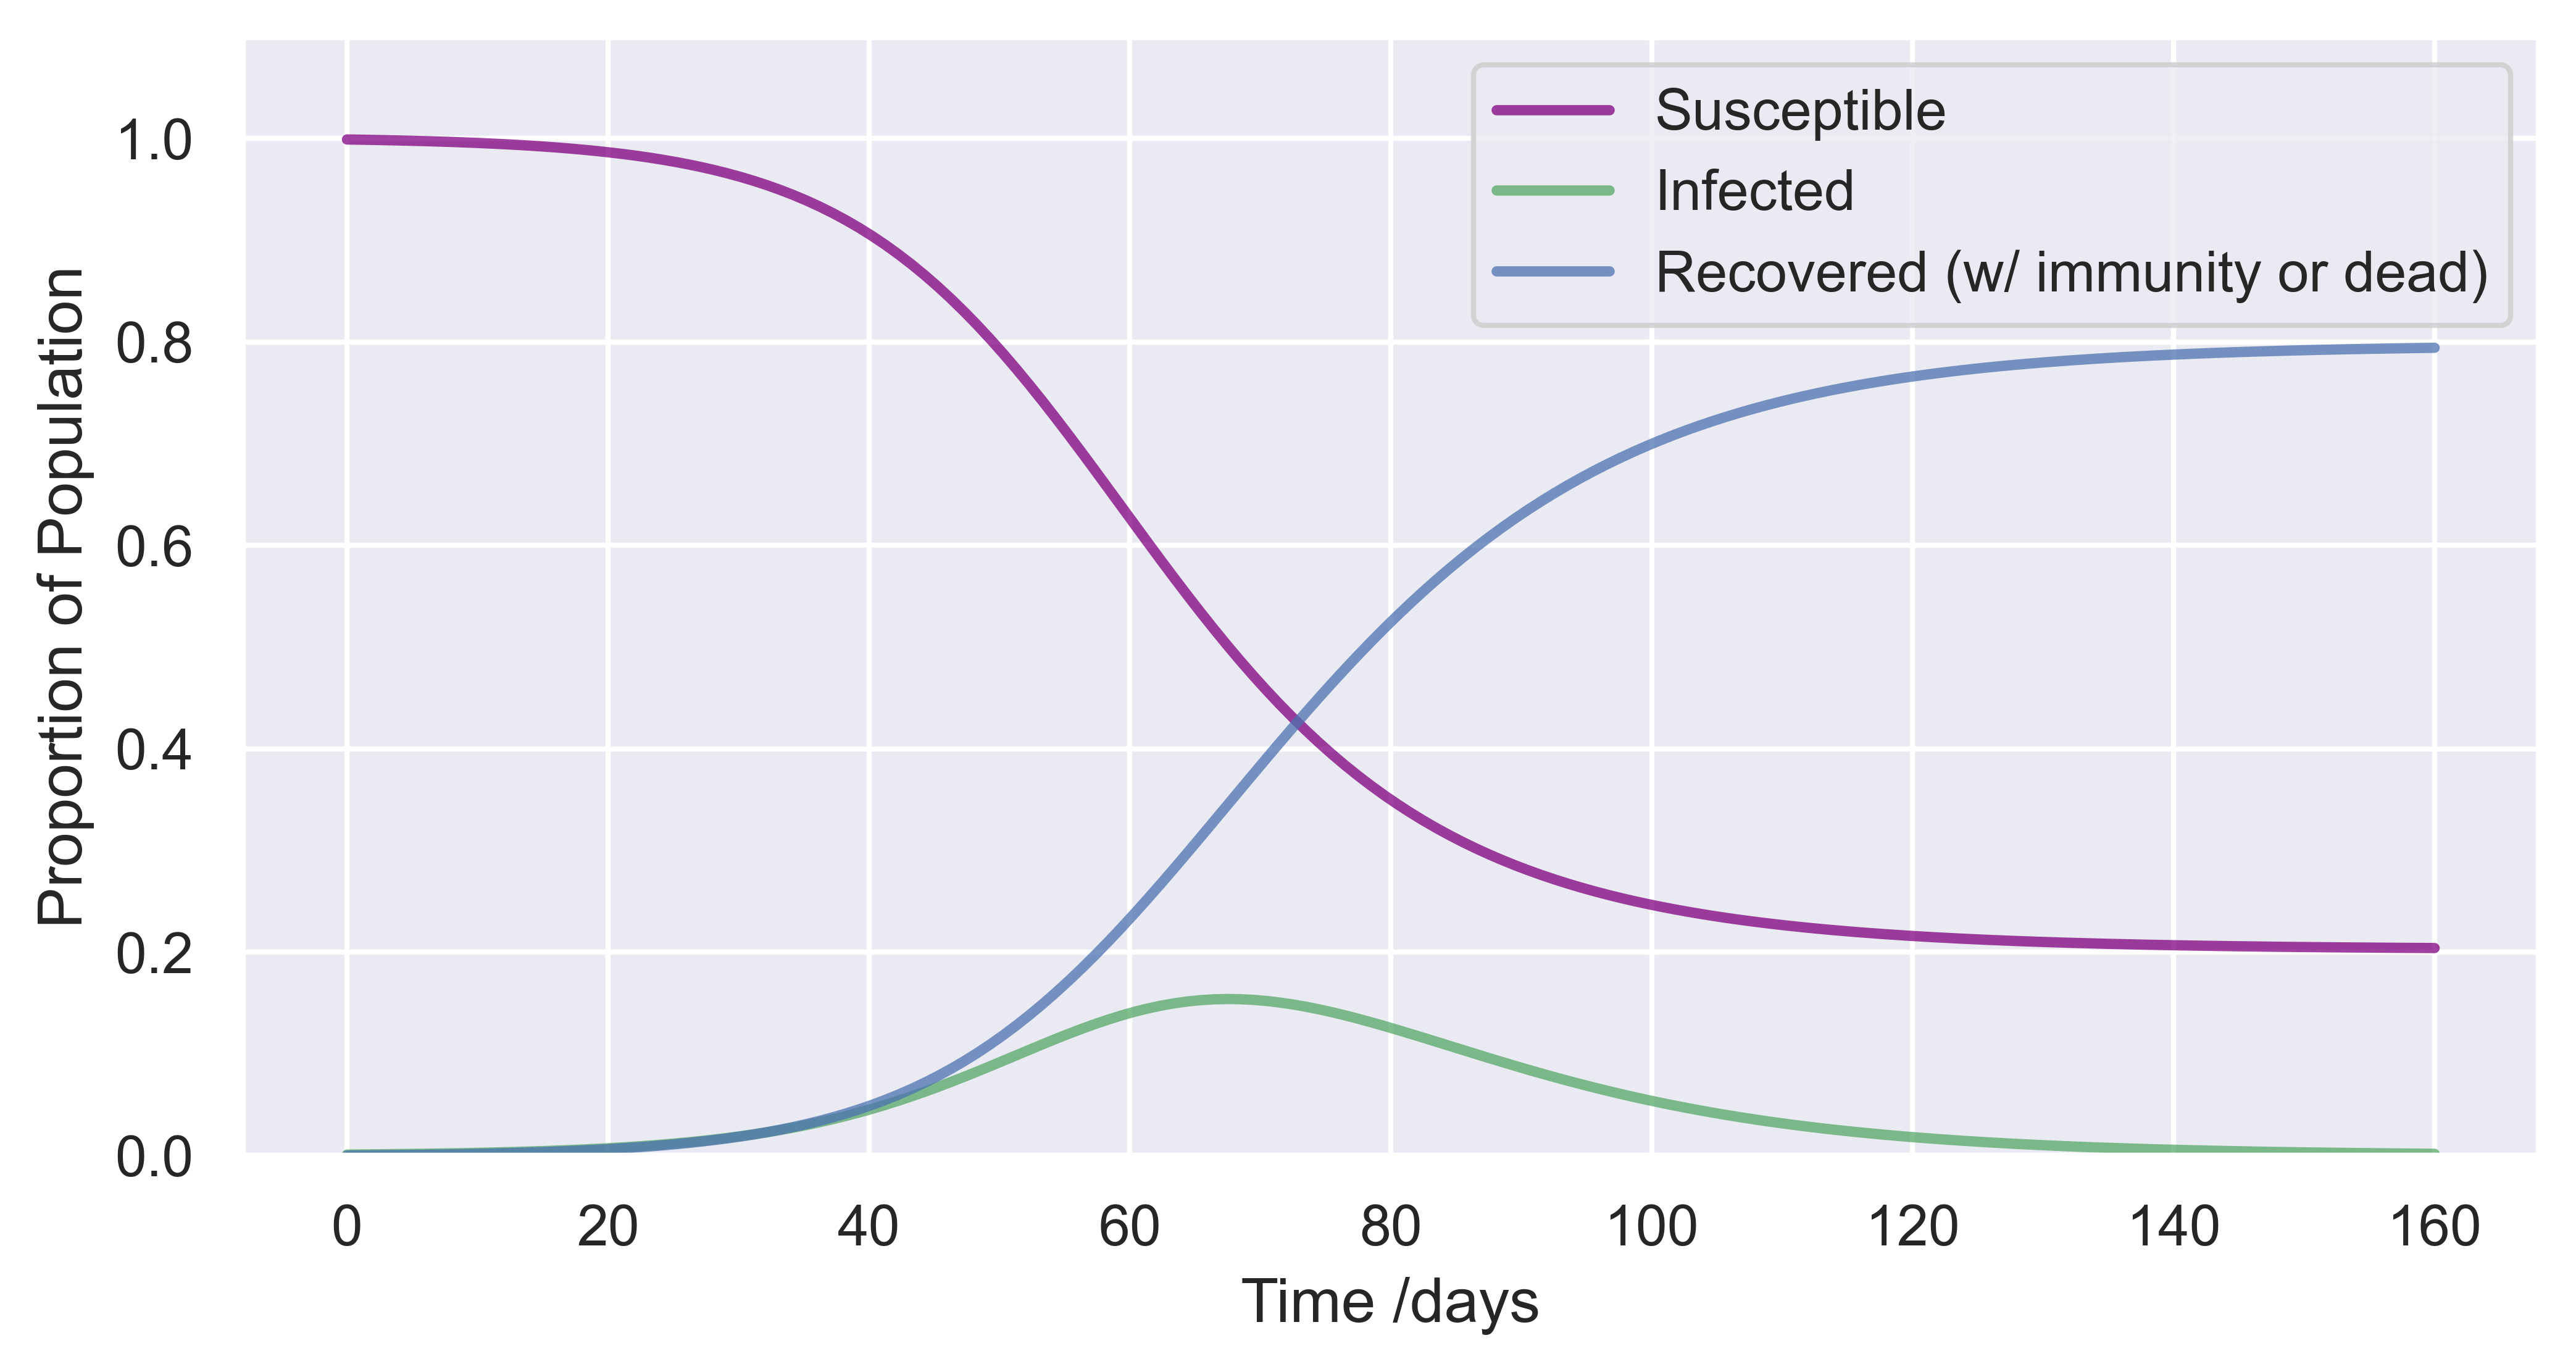

In [41]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(8,4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/N, 'purple', alpha=.75, lw=2, label='Susceptible')
ax.plot(t, I/N, 'g',      alpha=.75, lw=2, label='Infected')
ax.plot(t, R/N, 'b',      alpha=.75, lw=2, label='Recovered (w/ immunity or dead)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Proportion of Population')
ax.set_ylim(0,1.1)
# ax.yaxis.set_tick_params(length=0)
# ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)
plt.show()